In [109]:
import numpy as np
import scipy


epsilon = 1e-6
def generate_parameters_logit(n=10, max_logit=2, max_count=20, logit_mean=0.1):
    logits = logit_mean + np.random.uniform(-max_logit, max_logit, n)
    probabilities = scipy.special.expit(logits)
    
    counts = 1 + np.random.exponential(scale=max_count, size=n).astype(int)
    return probabilities, counts

def generate_parameters(n=10, max_count=20):
    # logits = logit_mean + np.random.uniform(-max_logit, max_logit, n)
    # probabilities = scipy.special.expit(logits)
    probabilities = np.random.uniform(epsilon, 1 - epsilon, n)
    
    counts = 1 + np.random.exponential(scale=max_count, size=n).astype(int)
    return probabilities, counts


In [110]:
def generate_experiments(k=1000, **kwargs):
    probabilities, counts = generate_parameters(**kwargs)
    
    target = []
    for p, c in zip(probabilities, counts):
        target.append(
            np.random.binomial(n=c, p=p, size=k)
        )
    target = np.column_stack(target)
    total = np.column_stack([counts] * k).T

    return target, total, probabilities

target, total, probabilities = generate_experiments(1000)

In [111]:
def get_optimal(target, total, probabilities):
    return [np.argmax(probabilities)] * total.shape[0]

np.mean(probabilities[get_optimal(target, total, probabilities)]).round(3)

0.944

In [112]:
def get_argmax(target, total, probabilities):
    return np.argmax(target / total, axis=1)

np.mean(probabilities[get_argmax(target, total, probabilities)]).round(3)

0.868

In [113]:
def get_random(target, total, probabilities):
    return np.random.randint(0, total.shape[1] - 1, total.shape[0])

np.mean(probabilities[get_random(target, total, probabilities)]).round(3)

0.646

In [114]:
strategies = [get_random, get_argmax, get_optimal]

In [115]:
import functools
def get_argmax_std_diff(target, total, probabilities, alpha=1.0):
    p_estimate = target / total
    q_estimate = 1 - p_estimate
    std = (p_estimate * (1 - q_estimate) / total) ** 0.5
    return np.argmax(p_estimate - std * alpha, axis=1)

def maximize_posteriori_expected_value(target: np.ndarray, total: np.ndarray, probabilities, alpha: float, beta: float) -> int:
    """Assuming apriori distribution on p_i ~ Beta(alpha, beta),
    and using that beta distribution is the conjugate to binomial r_i ~ Bin(p_i, n_i),
    evaluates hand index that maximizes expected value of posteriori distribution P(p_i | c_i, r_i) ~ Beta(alpha + k_i, alpha + beta + n_i)
    that is, (alpha + r_i) / (alpha + beta + n_i).
    
    n_hands: int - number of variants to choose from
    counts: 1-dim numpy array, len(counts) == n_hands. How many times we used each hand
    rewards: 1-dim numpy array, len(counts) == n_hands. Cumulative reward received from each hand. 
        By its nature 0 <= rewards[i] <= counts[i].
        
    Returns: index: int, from 0 to n_hands - 1 - index of chosen hand.
    """
    expected_posteriori_probabilities = (alpha + target) / (alpha + beta + total)
    return np.argmax(expected_posteriori_probabilities, axis=1)

def maximize_posteriori_expected_value_guess(target: np.ndarray, total: np.ndarray, probabilities) -> int:
    mean = (target / total).mean(axis=1)
    std = (target / total).std(axis=1)

    alpha = ((1 - mean) / std ** 2 - 1 / mean) * mean ** 2
    beta = alpha * (1 / mean - 1)
    # print(f"mean={mean.mean():.3f}, std={std.mean():.4f}, alpha={alpha.mean():.3f}, beta={beta.mean():.3f}")
    alpha = alpha.reshape(-1, 1)
    beta = beta.reshape(-1, 1)
    
    return maximize_posteriori_expected_value(target, total, probabilities, alpha, beta)


uniform_prior_strategy = functools.partial(maximize_posteriori_expected_value, alpha=1, beta=1)

In [117]:
import pandas as pd
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import itertools
from functools import partial


def check_strategies_once(strategies=[get_random, get_optimal], n_set=[10, 100, 1000], **kwargs):
    results = []

    for n in n_set:
        target, total, probabilities = generate_experiments(n=n, **kwargs)
        experiment_result = {'n': n}
        rank = pd.Series(probabilities).rank(ascending=False, method='first').values
        rank = (rank - 1) / rank.shape[0]
        for strategy in strategies:
            name = ''
            try:
                name = strategy.__name__
            except AttributeError:
                name = f'{strategy.func.__name__}:{strategy.keywords}'

            score = np.mean(probabilities[strategy(target, total, probabilities)])
            mean_rank = np.mean(rank[strategy(target, total, probabilities)])
            experiment_result[name] = score
            experiment_result[f'{name}_rank'] = mean_rank
        results.append(experiment_result)
    return results

def check_strategies_multi(strategies=[get_random, get_optimal], n_set=[10, 100, 1000], n_repeats=10, **kwargs):
    results = []
    print(n_set)

    results = Parallel(n_jobs=-1, verbose=1)(delayed(check_strategies_once)(
        strategies=strategies, n_set=n_set, **kwargs
    ) for i in tqdm(range(n_repeats)))

    return list(itertools.chain.from_iterable(results))

strategies = [
    get_argmax,
    get_optimal,
    uniform_prior_strategy,
    maximize_posteriori_expected_value_guess,
] # get_random

for alpha in np.linspace(0.5, 0.5, 1):
    s = partial(get_argmax_std_diff, alpha=alpha)
    strategies.append(
        s
    )

results = check_strategies_multi(
    strategies=strategies, 
    n_set=np.logspace(1, 2.5, 20).astype(int),
    # max_logit=3,
    k=1000,
    n_repeats=800,
)

[ 10  11  14  17  20  24  29  35  42  51  61  73  88 106 127 152 183 219
 263 316]


  0%|          | 0/800 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  1.3min finished


In [118]:
results = pd.DataFrame(results).set_index('n').sort_index()
results.sample(3).T

n,24,24,316
get_argmax,0.865269,0.787307,0.745393
get_argmax_rank,0.099500,0.198792,0.244582
get_optimal,0.948413,0.926290,0.997706
get_optimal_rank,0.000000,0.000000,0.000000
"maximize_posteriori_expected_value:{'alpha': 1, 'beta': 1}",0.936177,0.890676,0.967321
"maximize_posteriori_expected_value:{'alpha': 1, 'beta': 1}_rank",0.034000,0.074042,0.029104
maximize_posteriori_expected_value_guess,0.935472,0.891285,0.967867
maximize_posteriori_expected_value_guess_rank,0.032292,0.069667,0.028573
get_argmax_std_diff:{'alpha': 0.5},0.938839,0.886971,0.966245
get_argmax_std_diff:{'alpha': 0.5}_rank,0.038125,0.084417,0.030269


In [119]:
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(11.7,8.27)})

In [120]:
results[[s for s in results.columns if s.endswith('_rank')]].mean(axis=0).T.sort_values().round(4)

get_optimal_rank                                                   0.0000
maximize_posteriori_expected_value:{'alpha': 1, 'beta': 1}_rank    0.0392
get_argmax_std_diff:{'alpha': 0.5}_rank                            0.0403
maximize_posteriori_expected_value_guess_rank                      0.0403
get_argmax_rank                                                    0.1618
dtype: float64

In [121]:
results[[s for s in results.columns if not s.endswith('_rank')]].mean(axis=0).T.sort_values().round(4)

get_argmax                                                    0.8221
get_argmax_std_diff:{'alpha': 0.5}                            0.9407
maximize_posteriori_expected_value_guess                      0.9409
maximize_posteriori_expected_value:{'alpha': 1, 'beta': 1}    0.9418
get_optimal                                                   0.9715
dtype: float64

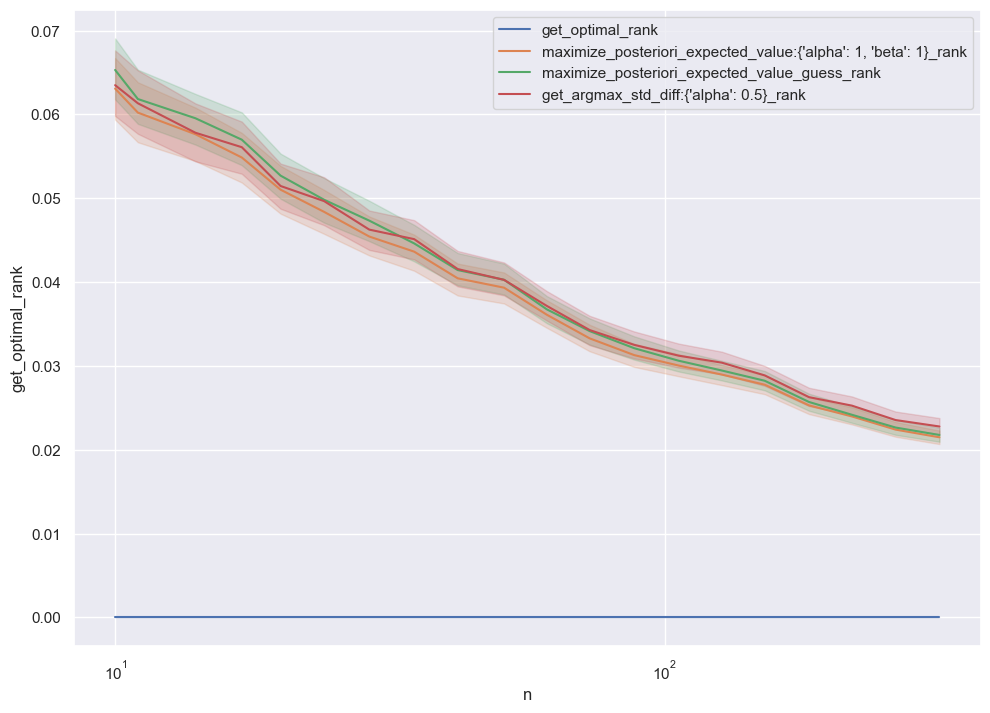

In [124]:
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(11.7,8.27)})

for strategy_name in [s for s in results.columns if s.endswith('_rank')]:
    if strategy_name == 'get_argmax_rank':
        continue
    plot = seaborn.lineplot(results, x='n', y=strategy_name, label=strategy_name)
    plot.set(xscale='log')

_ = plt.legend()

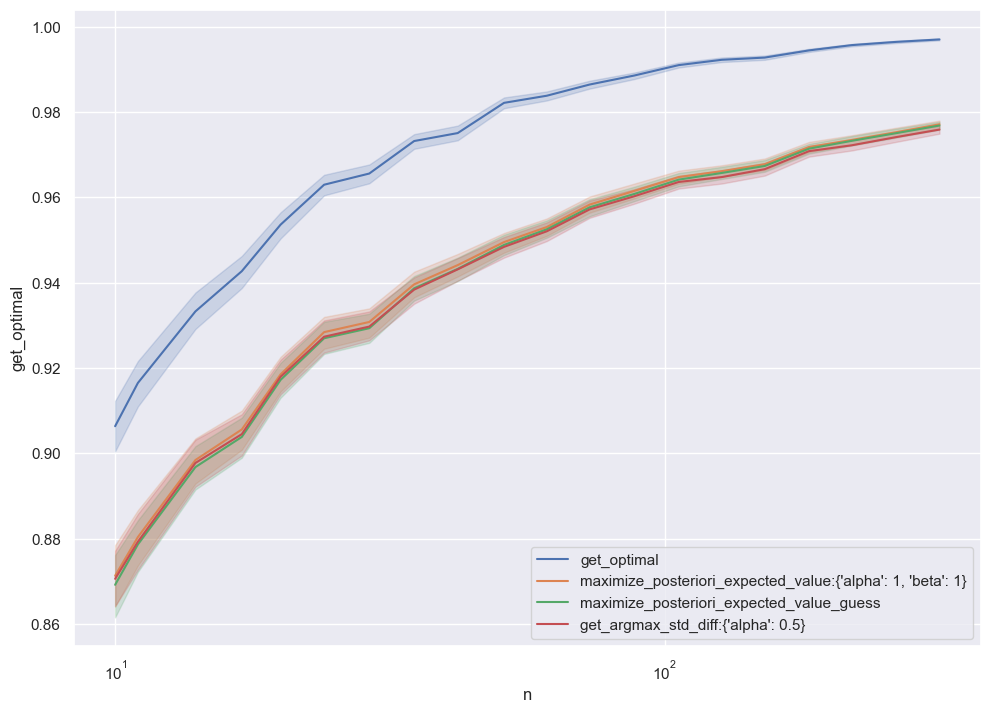

In [126]:
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(11.7,8.27)})

for strategy_name in [s for s in results.columns if not s.endswith('_rank')]:
    if strategy_name == 'get_argmax':
        continue
    plot = seaborn.lineplot(results, x='n', y=strategy_name, label=strategy_name)
    plot.set(xscale='log')

_ = plt.legend()